Problem Statement :  To build a classification methodology to predict the type of Thyroid a person has ,based on the below features.

age - Age of the person

sex - Male or Female

on_thyroxine - true or false

on_antithyroid_medication - true or false

sick - true or false

pregnant - true or false

thyroid_surgery - true or false

I131_treatment - true or false

query_hypothyroid - true or false

query_hyperthyroid -true or false

lithium - true or false

goitre - true or false

tumor - true or false

hypopituitary- true or false

psych - true or false

TSH_measured - true or false

TSH - thyroid stimulating hormone floating value

T3_measured - true or false

T3 - triiodothyronine value

TT4_measured- true or false

TT4 - Thyroxine value

T4U_measured- true or false

T4U - numerical value

FTI_measured- true or false

FTI -Free Thyroxine Index

TBG_measured- true or false

TBG -Thyroid-Binding Globulin  value

referral_source - different sources of referals

Class - different types of thyroid

In [401]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC,RandomOverSampler,KMeansSMOTE
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
sns.set()
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score,plot_confusion_matrix, roc_curve, auc
from pandas_profiling import ProfileReport

In [284]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [285]:
data  = pd.read_csv('/content/drive/MyDrive/data for colab/hypothyroid.csv')

In [286]:
data

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,2.5,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,2,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,?,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61,t,0.87,t,70,f,?,SVI,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,30,F,f,f,f,f,f,f,f,f,f,f,f,t,f,f,f,?,f,?,f,?,f,?,f,?,f,?,other,negative
3768,68,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1,t,2.1,t,124,t,1.08,t,114,f,?,SVI,negative
3769,74,F,f,f,f,f,f,f,f,f,t,f,f,f,f,f,t,5.1,t,1.8,t,112,t,1.07,t,105,f,?,other,negative
3770,72,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.7,t,2,t,82,t,0.94,t,87,f,?,SVI,negative


In [287]:
data.shape

(3772, 30)

In [288]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
0,41,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,1.3,t,2.5,t,125,t,1.14,t,109,f,?,SVHC,negative
1,23,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,4.1,t,2,t,102,f,?,f,?,f,?,other,negative
2,46,M,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.98,f,?,t,109,t,0.91,t,120,f,?,other,negative
3,70,F,t,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.16,t,1.9,t,175,f,?,f,?,f,?,other,negative
4,70,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,0.72,t,1.2,t,61,t,0.87,t,70,f,?,SVI,negative


In [289]:
data.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH_measured,TSH,T3_measured,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source,Class
count,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772
unique,94,3,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,288,2,70,2,242,2,147,2,235,1,1,5,4
top,59,F,f,f,f,f,f,f,f,f,f,f,f,f,f,f,t,?,t,?,t,?,t,?,t,?,f,?,other,negative
freq,95,2480,3308,3722,3729,3625,3719,3719,3713,3538,3535,3754,3738,3676,3771,3588,3403,369,3003,769,3541,231,3385,387,3387,385,3772,3772,2201,3481


It can be see that from the data description that there are no missing values. But if in the dataset the missing values are replaced with invalid values like '?'. So i replaced such values with 'nan' and checked for missing values again.

In [290]:
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count!=0:
        print(column, data[column][data[column]=='?'].count())    

age 1
sex 150
TSH 369
T3 769
TT4 231
T4U 387
FTI 385
TBG 3772


So these are the columns which have missing values but missing values are replaced with '?'. We will replace these values with 'nan' and then do imputation of these missing values. 

The column 'TBG' has all the values missing. So dropping this column as it is of no use.

Also, looking to the dataset, It can be see that some columns are with true and false value are just the indication that whether the next column has values or not. 

In [291]:
data = data.drop(['TBG'],axis =1)

In [292]:
#T4U_measured just showed that T4U has a value or not
data[['T4U_measured','T4U']] 

,T4U_measured,T4U
0,t,1.14
1,f,?
2,t,0.91
3,f,?
4,t,0.87
...,...,...
3767,f,?
3768,t,1.08
3769,t,1.07
3770,t,0.94


Since, there are missing values and we are gonna handle them, there is no point of having such columns just for indicating next column has value or not.
Dropping such columns as well.

In [293]:
data = data.drop(['TSH_measured','T3_measured','TT4_measured','T4U_measured','FTI_measured','TBG_measured'],axis =1)

In [294]:
# replacing the '?' values with numpy nan
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count!=0:
        data[column] = data[column].replace('?',np.nan)    

In [295]:
for column in data.columns:
    count = data[column][data[column]=='?'].count()
    if count==0:
        print(column, data[column][data[column]=='?'].count())    

age 0
sex 0
on_thyroxine 0
query_on_thyroxine 0
on_antithyroid_medication 0
sick 0
pregnant 0
thyroid_surgery 0
I131_treatment 0
query_hypothyroid 0
query_hyperthyroid 0
lithium 0
goitre 0
tumor 0
hypopituitary 0
psych 0
TSH 0
T3 0
TT4 0
T4U 0
FTI 0
referral_source 0
Class 0


Great!! Now that we have replaced all such values with 'nan'. Let's deal with these missing values now.

In [296]:
data.isna().sum()

age                            1
sex                          150
on_thyroxine                   0
query_on_thyroxine             0
on_antithyroid_medication      0
sick                           0
pregnant                       0
thyroid_surgery                0
I131_treatment                 0
query_hypothyroid              0
query_hyperthyroid             0
lithium                        0
goitre                         0
tumor                          0
hypopituitary                  0
psych                          0
TSH                          369
T3                           769
TT4                          231
T4U                          387
FTI                          385
referral_source                0
Class                          0
dtype: int64

Since the values are categorical, changing them to numerical before using any imputation techniques.

Using mapping for columns with two distinct values and get dummies where there are moer then two values why so because there are only two categories then the two columns formed after get dummies will both have very high correaltion since they both explain the same thing. 
So in anyway we got to drop one of the columns. That's why using mapping for such columns.

In [297]:
# for column in data.columns:
#     print(column, (data[column].unique()))

In [298]:
# mapping the categorical values like below:
data['sex'] = data['sex'].map({'F' : 0, 'M' : 1})

# except for 'Sex' column all the other columns with two categorical data have same value 'f' and 't'.
# so instead of mapping indvidually, usign a loop to do the mapping
for column in data.columns:
    if  len(data[column].unique())==2:
        data[column] = data[column].map({'f' : 0, 't' : 1})
        
# this will map all the rest of the columns. Now there are handful of column left with more than 2 categories. 

In [299]:
data['referral_source'].unique() #referel_source has 5 categories usign get dummies on it 

array(['SVHC', 'other', 'SVI', 'STMW', 'SVHD'], dtype=object)

In [300]:
# using get_dummies with that.
data = pd.get_dummies(data, columns=['referral_source'])

Now our ouptut class also has 4 distinct categories. There is no sense of using get dummies with our Output class, so just mapping them by using LabelEncoder function for this.

In [301]:
data['Class'].unique()

array(['negative', 'compensated_hypothyroid', 'primary_hypothyroid',
       'secondary_hypothyroid'], dtype=object)

In [302]:
lblEn = LabelEncoder()

data['Class'] =lblEn.fit_transform(data['Class'])

In [303]:
data.head()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,41,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.3,2.5,125,1.14,109,1,0,1,0,0,0
1,23,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.1,2,102,NaN,NaN,1,0,0,0,0,1
2,46,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.98,NaN,109,0.91,120,1,0,0,0,0,1
3,70,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.16,1.9,175,NaN,NaN,1,0,0,0,0,1
4,70,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.72,1.2,61,0.87,70,1,0,0,0,1,0


In [304]:
data.describe(include='all')

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3771,3622.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3403,3003,3541,3385,3387,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
unique,93,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,287,69,241,146,234,NaN,NaN,NaN,NaN,NaN,NaN
top,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2,2,101,0.99,100,NaN,NaN,NaN,NaN,NaN,NaN
freq,95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,116,238,71,95,73,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.315295,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,0.062831,0.004772,0.009014,0.025451,0.000265,0.048780,NaN,NaN,NaN,NaN,NaN,0.974814,0.029692,0.102333,0.010339,0.274125,0.583510
std,NaN,0.464698,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,0.242692,0.068924,0.094525,0.157510,0.016282,0.215437,NaN,NaN,NaN,NaN,NaN,0.279508,0.169760,0.303126,0.101169,0.446131,0.493042
min,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000


In [305]:
# for column in data.columns:
#     print(column, (data[column].unique()))

All the encoding for Categorical values is done. Imputing the missing values using KNN Imputer.

In [306]:
imputer=KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
new_array=imputer.fit_transform(data) # impute the missing values
# converting the nd-array returned in the step above to a Dataframe
new_data=pd.DataFrame(data=np.round(new_array), columns=data.columns)

In [307]:
new_data.describe()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,TSH,T3,TT4,T4U,FTI,Class,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
count,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000,3772.000000
mean,51.737275,0.307529,0.123012,0.013256,0.011400,0.038971,0.014051,0.014051,0.015642,0.062036,0.062831,0.004772,0.009014,0.025451,0.000265,0.048780,4.831124,2.027306,108.459438,1.020944,110.301166,0.974814,0.029692,0.102333,0.010339,0.274125,0.583510
std,20.082478,0.461532,0.328494,0.114382,0.106174,0.193552,0.117716,0.117716,0.124101,0.241253,0.242692,0.068924,0.094525,0.157510,0.016282,0.215437,23.323816,0.785068,34.838114,0.165546,32.145618,0.279508,0.169760,0.303126,0.101169,0.446131,0.493042
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,36.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,88.000000,1.000000,93.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,104.000000,1.000000,107.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,67.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2.000000,124.000000,1.000000,124.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,455.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,530.000000,11.000000,430.000000,2.000000,395.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [308]:
new_data.isna().sum()

age                          0
sex                          0
on_thyroxine                 0
query_on_thyroxine           0
on_antithyroid_medication    0
sick                         0
pregnant                     0
thyroid_surgery              0
I131_treatment               0
query_hypothyroid            0
query_hyperthyroid           0
lithium                      0
goitre                       0
tumor                        0
hypopituitary                0
psych                        0
TSH                          0
T3                           0
TT4                          0
T4U                          0
FTI                          0
Class                        0
referral_source_STMW         0
referral_source_SVHC         0
referral_source_SVHD         0
referral_source_SVI          0
referral_source_other        0
dtype: int64

Now there are no missing values in the new dataset. 


Checking the distribution for continous data in the dataset:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

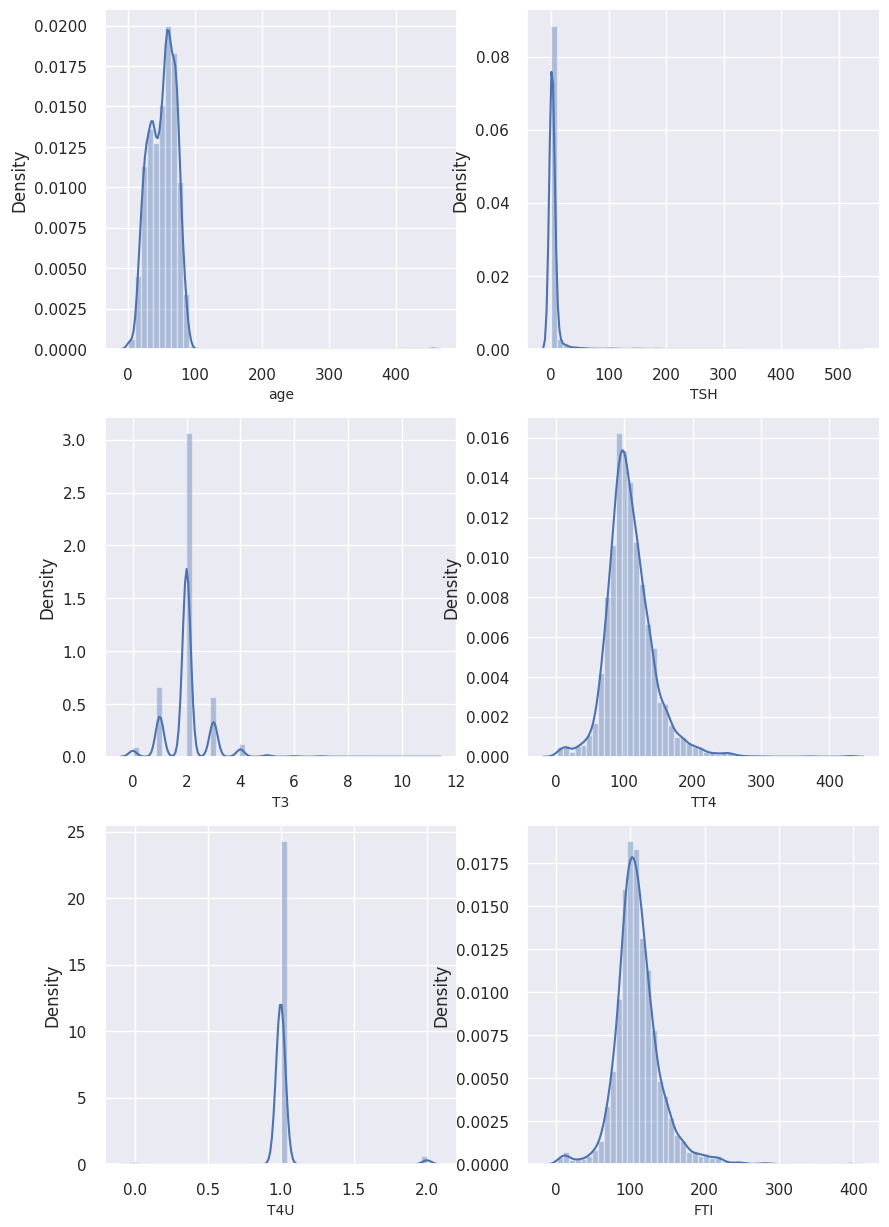

In [309]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plot.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    ax = plot.subplot(3,2,plotnumber)
    sns.distplot(new_data[column])
    plot.xlabel(column,fontsize=10)
    plotnumber+=1
plot.show()

The graphs for age, TSH and T3 looks heavely skewed towards left. Let's do some transformations to the data and see if it improves the plot.

Before doing log transformation , let's add 1 to each valuue in the column to handle exception when we try to find log of '0'.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

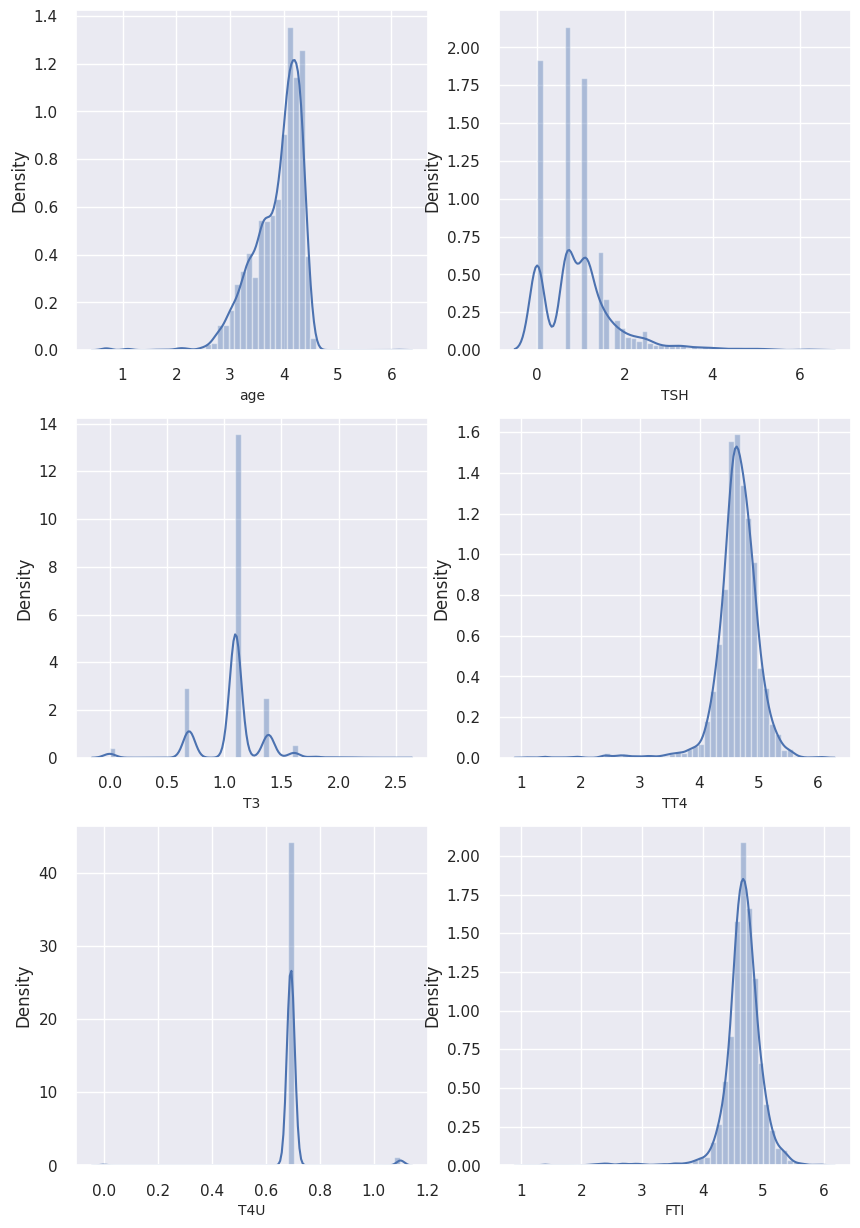

In [310]:
columns = ['age','TSH','T3','TT4','T4U','FTI']

plot.figure(figsize=(10,15),facecolor='white')
plotnumber = 1

for column in columns:
    new_data[column]+=1
    ax = plot.subplot(3,2,plotnumber)
    sns.distplot(np.log(new_data[column]))
    plot.xlabel(column,fontsize=10)
    plotnumber+=1
plot.show()

After log transformation, rest of the columns look fine but 'TSH' has a weird trend.

It won't give much of information so dropping this column.

In [311]:
new_data = new_data.drop(['TSH'],axis=1)


#### Checking how balanced the dataset in terms of given target classes:

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


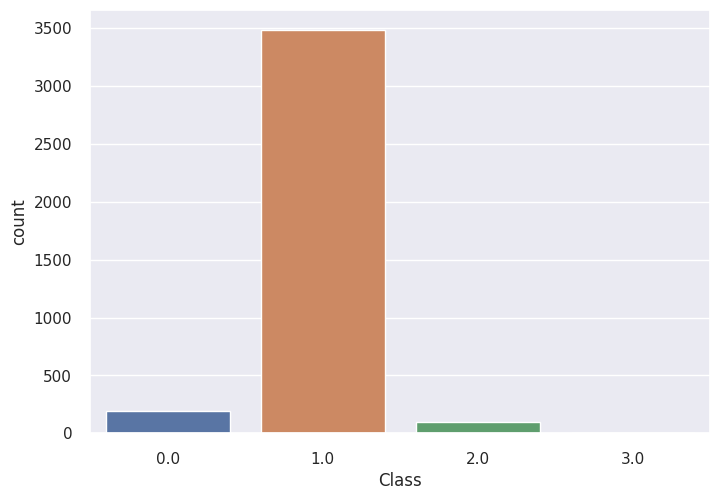

In [312]:
sns.countplot(new_data['Class'])   

the dataset is highly imbalanced. 

using imbalanced-learn to deal with imbalanced data.

Imbalanced learn has an algorithm called RandomOverSampler. 

Note: https://pypi.org/project/imbalanced-learn/

https://github.com/scikit-learn-contrib/imbalanced-learn


# Handling imbalanced dataset
https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/



In [313]:
x = new_data.drop(['Class'],axis=1)
y = new_data['Class']
rdsmple = RandomOverSampler()
x_sampled,y_sampled  = rdsmple.fit_resample(x,y)

In [314]:
rdsmple = RandomOverSampler()
x_sampled,y_sampled  = rdsmple.fit_resample(x,y)

In [315]:
x_sampled.shape

(13924, 25)

In [316]:
x_sampled = pd.DataFrame(data = x_sampled, columns = x.columns)

In [317]:
x_sampled

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0
13920,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0
13921,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0
13922,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


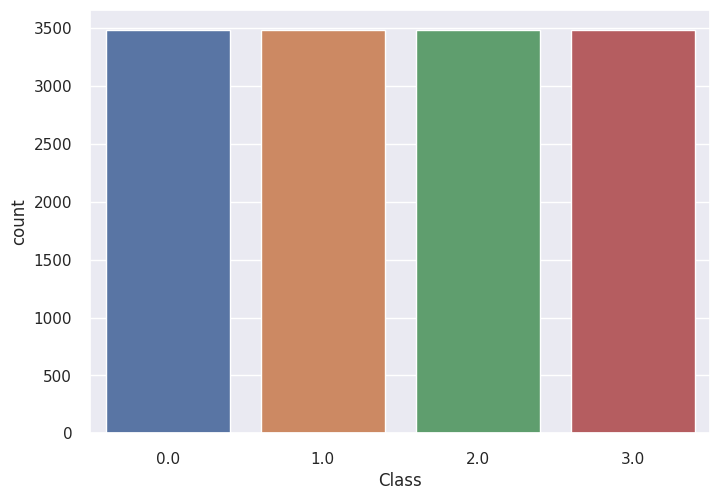

In [318]:
sns.countplot(y_sampled)       

The dataset looks balanced now. 

Checking for corelations in dataset

In [319]:
#combining the data and keeping it 
combined_data = pd.concat([x_sampled, y_sampled], axis=1)
combined_data

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other,Class
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,126.0,2.0,110.0,0.0,1.0,0.0,0.0,0.0,1.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,103.0,2.0,109.0,0.0,0.0,0.0,0.0,1.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,110.0,2.0,121.0,0.0,0.0,0.0,0.0,1.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,176.0,2.0,178.0,0.0,0.0,0.0,0.0,1.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,62.0,2.0,71.0,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0,3.0
13920,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0,3.0
13921,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,49.0,2.0,55.0,0.0,0.0,0.0,0.0,1.0,3.0
13922,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,23.0,2.0,58.0,0.0,0.0,0.0,0.0,1.0,3.0


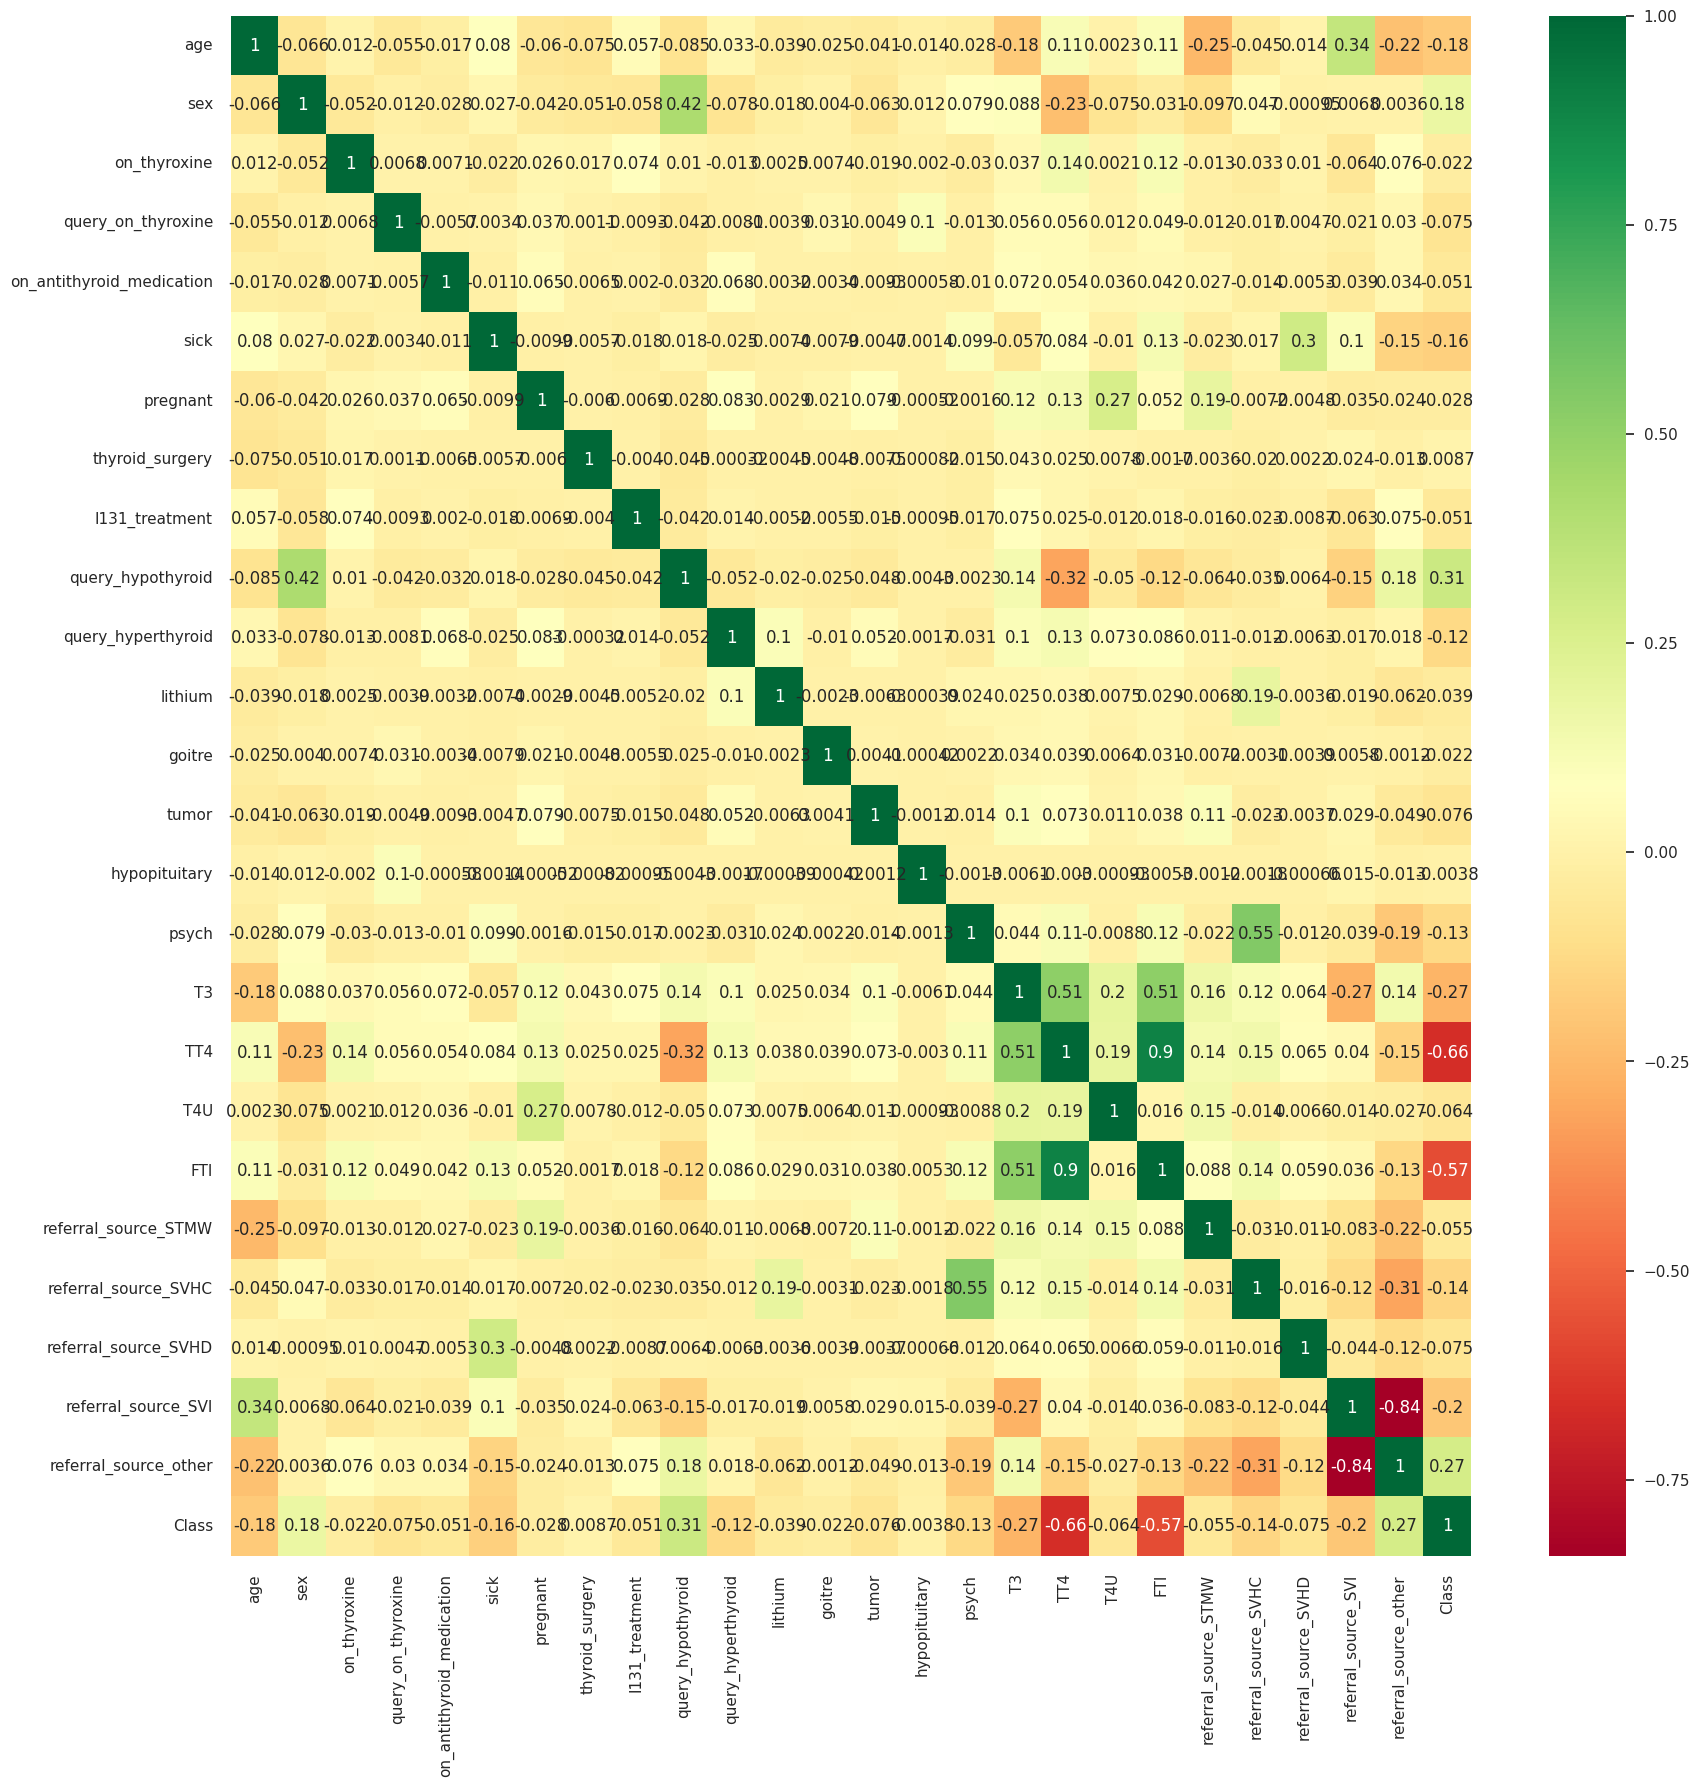

In [320]:
#get correlations of each features in dataset
corrmat = combined_data.corr()
top_corr_features = corrmat.index
plot.figure(figsize=(20,20))
#plot heat map
sns.heatmap(combined_data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

We can see target class is negatively corelated with TT4 and FTI 

In [321]:
combined_data.corr()

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,TT4,T4U,FTI,referral_source_STMW,referral_source_SVHC,referral_source_SVHD,referral_source_SVI,referral_source_other,Class
age,1.000000,-0.066017,0.012145,-0.055066,-0.016788,0.079847,-0.060264,-0.074583,0.057028,-0.084879,0.033307,-0.038904,-0.024602,-0.040995,-0.014022,-0.028001,-0.181726,0.108893,0.002258,0.105174,-0.246810,-0.045345,0.013663,0.340510,-0.221568,-0.182081
sex,-0.066017,1.000000,-0.052233,-0.011695,-0.027821,0.027391,-0.041938,-0.050773,-0.057682,0.420191,-0.077818,-0.018191,0.004018,-0.062692,0.012491,0.078844,0.088076,-0.228755,-0.075366,-0.030559,-0.097139,0.046903,-0.000954,0.006754,0.003601,0.179118
on_thyroxine,0.012145,-0.052233,1.000000,0.006817,0.007120,-0.022077,0.026329,0.016731,0.073552,0.010161,-0.013080,0.002521,0.007390,-0.018576,-0.002032,-0.030227,0.036907,0.140460,0.002147,0.120058,-0.012987,-0.032964,0.009953,-0.063660,0.075578,-0.021673
query_on_thyroxine,-0.055066,-0.011695,0.006817,1.000000,-0.005662,0.003383,0.037134,0.001069,-0.009318,-0.042288,-0.008056,-0.003872,0.031049,-0.004907,0.101713,-0.012718,0.055592,0.055934,0.012076,0.049405,-0.012195,-0.017480,0.004717,-0.020965,0.029968,-0.075301
on_antithyroid_medication,-0.016788,-0.027821,0.007120,-0.005662,1.000000,-0.010864,0.064770,-0.006545,0.002013,-0.031857,0.067733,-0.003158,-0.003362,-0.009281,-0.000576,-0.010372,0.071759,0.054070,0.035756,0.041740,0.027105,-0.014256,-0.005294,-0.038541,0.034367,-0.051282
sick,0.079847,0.027391,-0.022077,0.003383,-0.010864,1.000000,-0.009882,-0.005744,-0.017879,0.018180,-0.025435,-0.007429,-0.007910,-0.004655,-0.001355,0.099150,-0.056832,0.083706,-0.009968,0.126347,-0.023398,0.016900,0.296926,0.104722,-0.146647,-0.158444
pregnant,-0.060264,-0.041938,0.026329,0.037134,0.064770,-0.009882,1.000000,-0.005954,-0.006913,-0.028482,0.082983,-0.002872,0.020573,0.078540,-0.000524,-0.001616,0.119489,0.132306,0.268337,0.051907,0.194442,-0.007164,-0.004816,-0.035059,-0.023738,-0.027644
thyroid_surgery,-0.074583,-0.050773,0.016731,0.001069,-0.006545,-0.005744,-0.005954,1.000000,-0.003959,-0.045157,-0.000322,-0.004476,-0.004766,-0.007544,-0.000816,-0.014702,0.042779,0.025394,0.007840,-0.001712,-0.003594,-0.020208,0.002214,0.024280,-0.012976,0.008750
I131_treatment,0.057028,-0.057682,0.073552,-0.009318,0.002013,-0.017879,-0.006913,-0.003959,1.000000,-0.042260,0.013880,-0.005197,-0.005533,-0.015275,-0.000948,-0.017070,0.075181,0.025451,-0.012216,0.018457,-0.016368,-0.023462,-0.008713,-0.063431,0.075409,-0.051178
query_hypothyroid,-0.084879,0.420191,0.010161,-0.042288,-0.031857,0.018180,-0.028482,-0.045157,-0.042260,1.000000,-0.052186,-0.019746,-0.025110,-0.048086,-0.004301,-0.002303,0.135616,-0.315962,-0.049648,-0.123840,-0.064345,-0.034744,0.006422,-0.154329,0.176754,0.314995


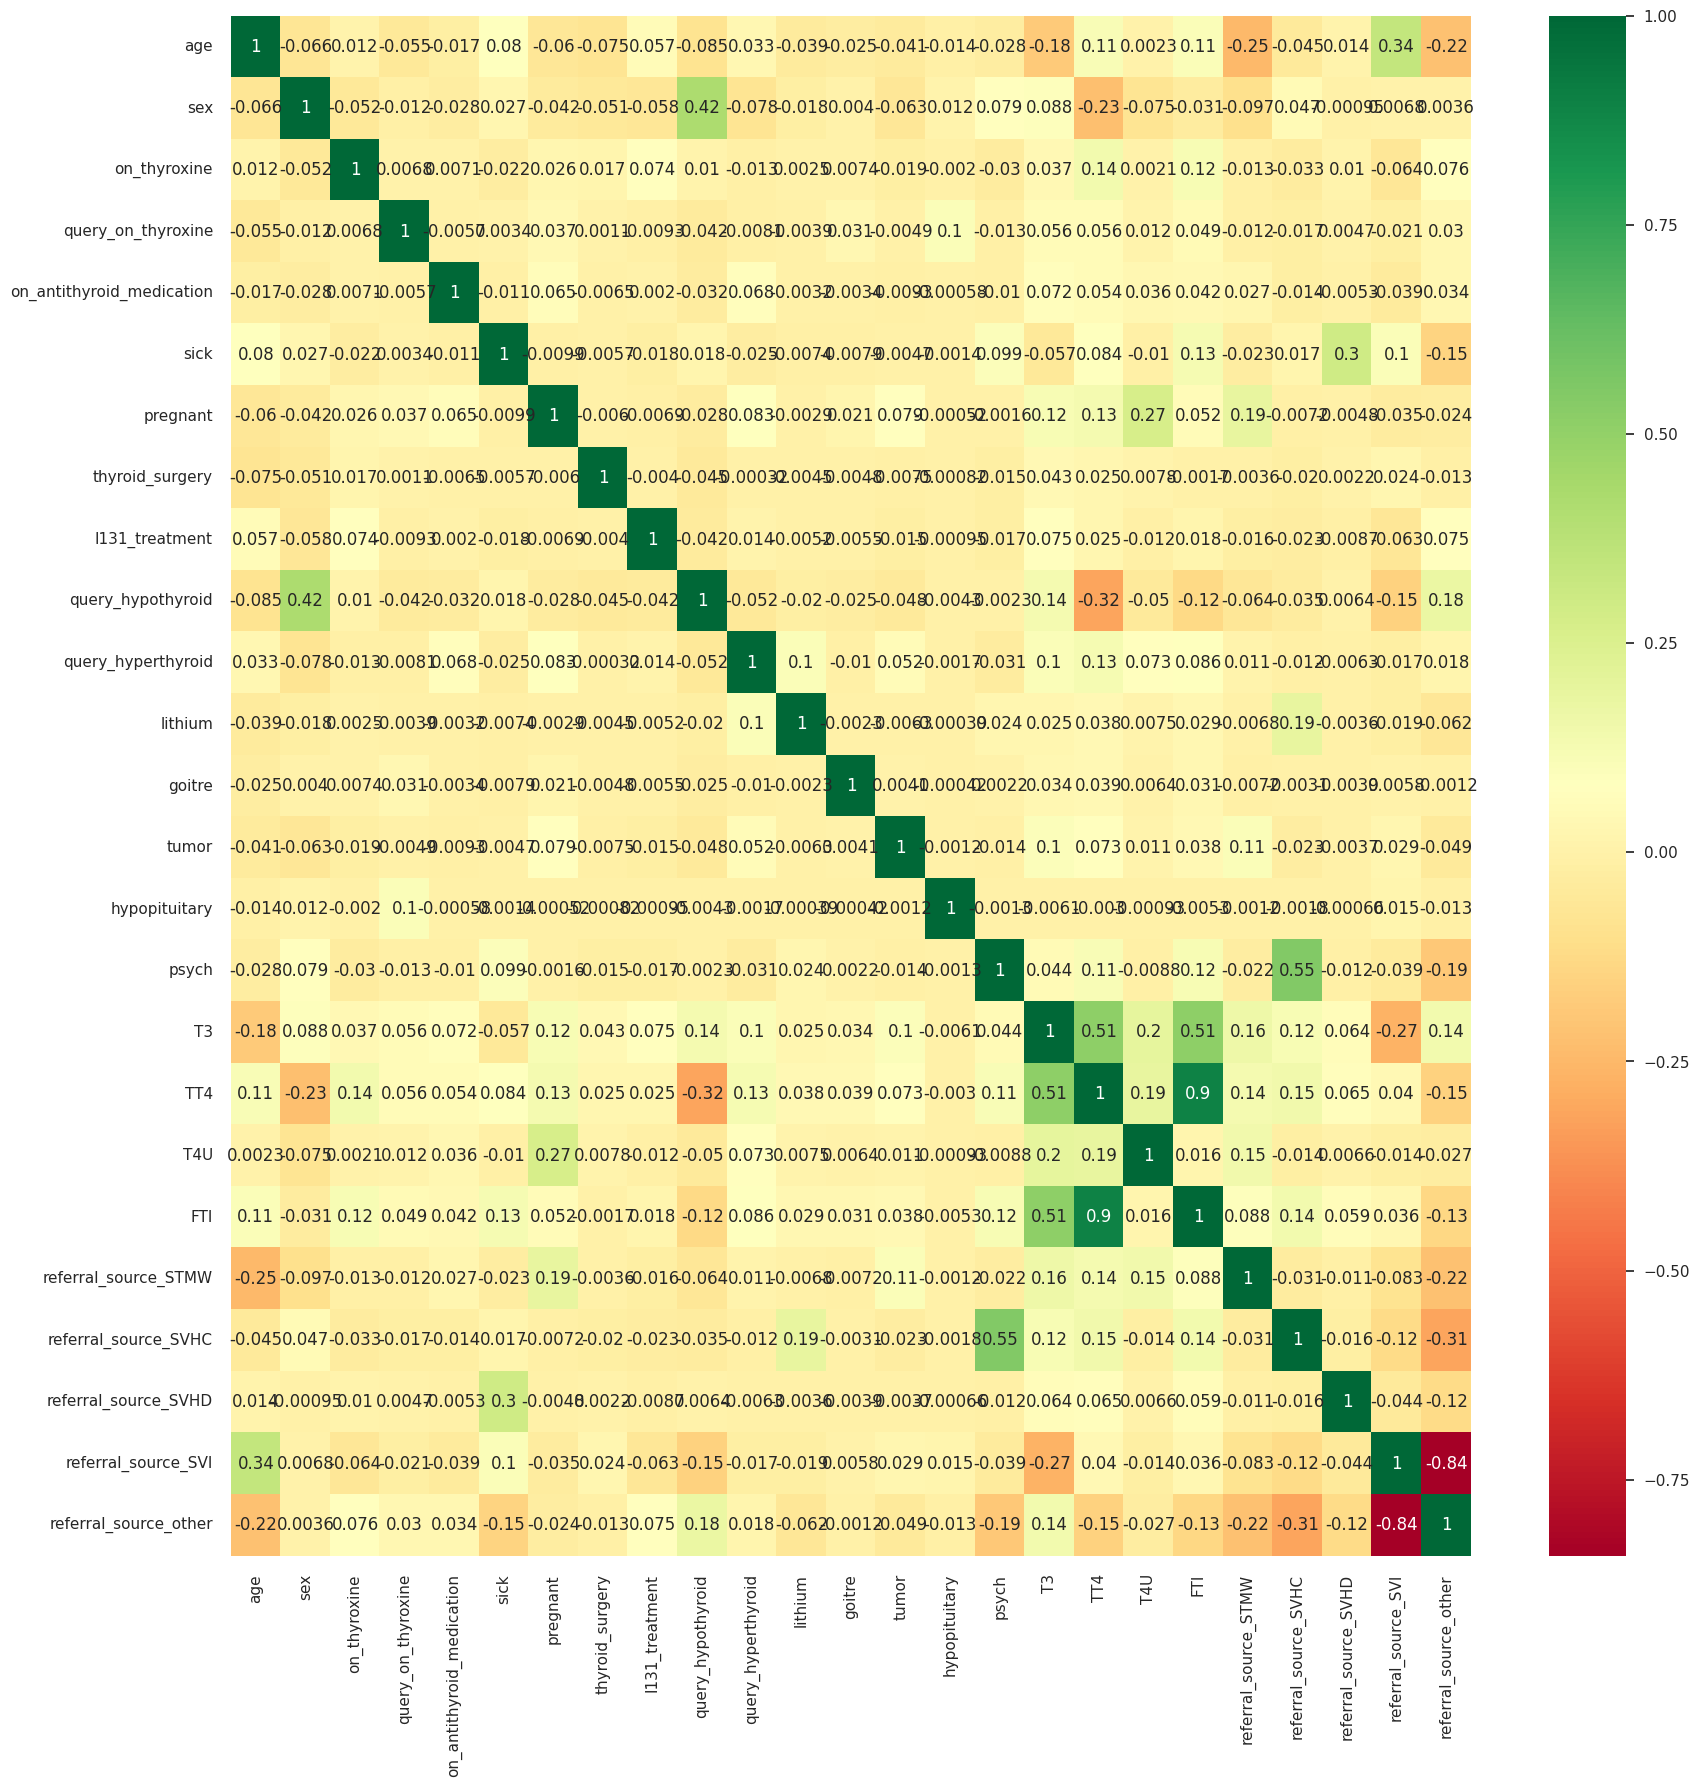

In [334]:
#same corealations can be seend on sampled data with out the target class 
#get correlations of each features in dataset
corrmat = x_sampled.corr()
top_corr_features = corrmat.index
plot.figure(figsize=(20,20))
#plot heat map
sns.heatmap(x_sampled[top_corr_features].corr(),annot=True,cmap="RdYlGn")

Checking the VIF score for multicollinearity

In [322]:
def vif_score(x):
    scaler = StandardScaler() # performing scaling on data without output class 
    arr = scaler.fit_transform(x)
    return pd.DataFrame([[x.columns[i], variance_inflation_factor(arr,i)] for i in range(arr.shape[1])], columns=["FEATURE", "VIF_SCORE"])

In [323]:
vif_score(x_sampled)

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,FEATURE,VIF_SCORE
0,age,1.300688
1,sex,1.447283
2,on_thyroxine,1.053836
3,query_on_thyroxine,1.024874
4,on_antithyroid_medication,1.015701
5,sick,1.170974
6,pregnant,1.132981
7,thyroid_surgery,1.020094
8,I131_treatment,1.033911
9,query_hypothyroid,1.604425


We can see that the data has multicollinearity the features which are depicting that are referral_source_STMW, referral_source_SVHC, referral_source_SVHD	referral_source_SVI, referral_source_other, TT4 and FTI	 so dropping the first four referral_source_STMW, referral_source_SVHC, referral_source_SVHD	referral_source_SVI, TT4 and FTI for preventing multicollinearity

In [335]:
x_sampled.drop('referral_source_STMW', axis=1, inplace = True)

In [336]:
x_sampled.drop('referral_source_SVHC', axis=1, inplace = True)

In [337]:
x_sampled.drop('referral_source_SVHD', axis=1, inplace = True)

In [338]:
x_sampled.drop('referral_source_SVI', axis=1, inplace = True)

In [339]:
x_sampled.drop('TT4', axis=1, inplace = True)

In [340]:
x_sampled.drop('FTI', axis=1, inplace = True)

In [341]:
x_sampled

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,query_hyperthyroid,lithium,goitre,tumor,hypopituitary,psych,T3,T4U,referral_source_other
0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0
1,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0
2,47.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0
3,71.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0
4,71.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13919,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0
13920,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0
13921,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0
13922,42.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0


In [343]:
# checking VIF score agian 
vif_score(x_sampled)

,FEATURE,VIF_SCORE
0,age,1.118853
1,sex,1.256280
2,on_thyroxine,1.017300
3,query_on_thyroxine,1.022185
4,on_antithyroid_medication,1.015399
5,sick,1.035234
6,pregnant,1.102977
7,thyroid_surgery,1.014121
8,I131_treatment,1.029230
9,query_hypothyroid,1.287591


Now we can see that multicollinearity is not present in the data proceding ahead with training the model using different algorithms 

In [347]:
#scaling down the sampled data before it was done in function only to check the vif score 
scalar = StandardScaler()
X_scaled = scalar.fit_transform(x_sampled)
X_scaled

array([[-0.48696075, -0.67845718, -0.23977534, ...,  0.50148957,
        -0.10923085, -1.48305379],
       [-1.53781183, -0.67845718, -0.23977534, ...,  0.50148957,
        -0.10923085,  0.67428438],
       [-0.19505767,  1.47393238, -0.23977534, ...,  0.50148957,
        -0.10923085,  0.67428438],
       ...,
       [-0.19505767, -0.67845718, -0.23977534, ..., -0.72226451,
        -0.10923085,  0.67428438],
       [-0.48696075,  1.47393238, -0.23977534, ...,  0.50148957,
        -0.10923085,  0.67428438],
       [-0.48696075,  1.47393238, -0.23977534, ...,  0.50148957,
        -0.10923085,  0.67428438]])

In [438]:
y_sampled.unique()

array([1., 0., 2., 3.])

In [441]:
# performing train test split
x_train, x_test, y_train, y_test = train_test_split(X_scaled , y_sampled , test_size = .20 , random_state = 144) #using 20% of data as test set

In [442]:
x_train

array([[-0.19505767, -0.67845718, -0.23977534, ..., -0.72226451,
        -0.10923085,  0.67428438],
       [-0.19505767, -0.67845718, -0.23977534, ..., -0.72226451,
        -0.10923085,  0.67428438],
       [-1.4210506 , -0.67845718, -0.23977534, ..., -0.72226451,
        -0.10923085, -1.48305379],
       ...,
       [-1.12914752, -0.67845718, -0.23977534, ..., -0.72226451,
        -0.10923085,  0.67428438],
       [ 1.32283833, -0.67845718, -0.23977534, ...,  0.50148957,
        -0.10923085,  0.67428438],
       [-0.83724444, -0.67845718, -0.23977534, ...,  0.50148957,
        -0.10923085,  0.67428438]])

In [443]:
x_test

array([[-1.47943121, -0.67845718, -0.23977534, ..., -0.72226451,
        -0.10923085,  0.67428438],
       [-1.30428937, -0.67845718, -0.23977534, ...,  0.50148957,
        -0.10923085, -1.48305379],
       [-0.42858013, -0.67845718, -0.23977534, ..., -0.72226451,
        -0.10923085,  0.67428438],
       ...,
       [-0.19505767, -0.67845718, -0.23977534, ..., -0.72226451,
        -0.10923085,  0.67428438],
       [ 0.73903218,  1.47393238, -0.23977534, ...,  0.50148957,
        -0.10923085,  0.67428438],
       [-0.66210259, -0.67845718, -0.23977534, ...,  0.50148957,
        -0.10923085, -1.48305379]])

In [444]:
y_test

8668     2.0
4743     0.0
9412     2.0
705      1.0
6282     0.0
        ... 
209      1.0
12895    3.0
12708    3.0
4139     0.0
149      1.0
Name: Class, Length: 2785, dtype: float64

In [459]:
y_test

8668     2.0
4743     0.0
9412     2.0
705      1.0
6282     0.0
        ... 
209      1.0
12895    3.0
12708    3.0
4139     0.0
149      1.0
Name: Class, Length: 2785, dtype: float64

In [445]:
x_test[0]

array([-1.47943121, -0.67845718, -0.23977534, -0.08332128, -0.06795296,
       -0.15986847, -0.0618136 , -0.09632264, -0.11183591, -0.50753   ,
       -0.20336707, -0.04646725, -0.04947529, -0.13658459, -0.00847488,
       -0.152633  , -0.72226451, -0.10923085,  0.67428438])

In [446]:
logisticregression_liblinear = LogisticRegression(verbose=1,solver='liblinear')

In [447]:
logisticregression_liblinear.fit(x_train,y_train )

[LibLinear]

LogisticRegression(solver='liblinear', verbose=1)

In [448]:
logisticregression_liblinear.predict(x_test)

array([3., 0., 3., ..., 3., 1., 1.])

In [449]:
logisticregression_liblinear.predict([x_test[1]])

array([0.])

In [450]:
logisticregression_liblinear.predict_log_proba([x_test[1]])

array([[-1.03363793, -1.0942225 , -1.17374087, -8.17514558]])

In [466]:
y_pred_liblinear_probility = logisticregression_liblinear.predict_log_proba(x_test)
y_pred_liblinear_probility

array([[-1.95360803e+00, -3.18839873e+00, -9.25129438e-01,
        -8.66262322e-01],
       [-1.03363793e+00, -1.09422250e+00, -1.17374087e+00,
        -8.17514558e+00],
       [-1.64808165e+00, -2.71959084e+00, -1.02569965e+00,
        -9.59370260e-01],
       ...,
       [-1.58293374e+00, -2.61815948e+00, -1.05379192e+00,
        -9.85967799e-01],
       [-1.38626192e+00, -6.77494440e-01, -2.98448742e+00,
        -1.65266628e+00],
       [-6.87763834e+00, -2.07776212e-03, -6.86505849e+00,
        -1.34729042e+01]])

In [452]:
y_test.iloc[1]

0.0

In [453]:
y_pred_liblinear = logisticregression_liblinear.predict(x_test)
y_pred_liblinear

array([3., 0., 3., ..., 3., 1., 1.])

[[291 216  98 103]
 [198 384  91  39]
 [ 92  65 367 129]
 [  0   0   0 712]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


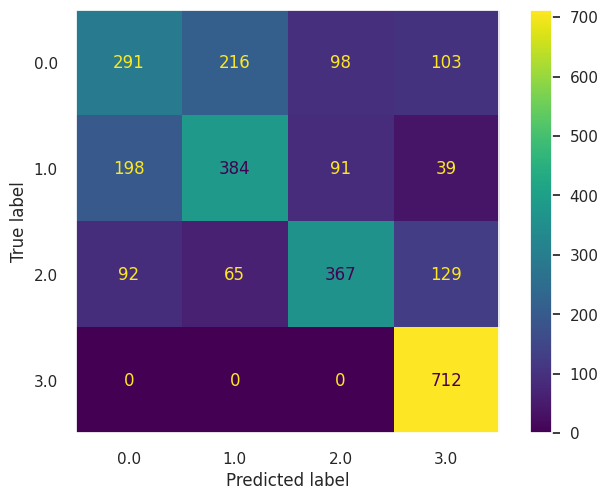

In [454]:
# confusion_matrix funnction a matrix containing the summary of predictions
print(confusion_matrix(y_test, y_pred_liblinear))


# plot_confusion_matrix function is used to visualize the confusion matrix
plot_confusion_matrix(logisticregression_liblinear, x_test, y_test)
plot.grid(False)
plot.show()

In [455]:
print(f"Accuracy of the logisticregression_liblinear classifier is: {accuracy_score(y_test, y_pred_liblinear)}")
print(f"Precision Score of the logisticregression_liblinear classifier is: {precision_score(y_test, y_pred_liblinear, average='micro')}")
print(f"Recall Score of the logisticregression_liblinear classifier is: {recall_score(y_test, y_pred_liblinear, average='micro')}")
print(f"Recall Score of the logisticregression_liblinear classifier is: {recall_score(y_test, y_pred_liblinear, average='micro')}")

Accuracy of the logisticregression_liblinear classifier is: 0.629802513464991
Precision Score of the logisticregression_liblinear classifier is: 0.629802513464991
Recall Score of the logisticregression_liblinear classifier is: 0.629802513464991
Recall Score of the logisticregression_liblinear classifier is: 0.629802513464991


In [471]:
from sklearn import preprocessing
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
  lb = preprocessing.LabelBinarizer()
  lb.fit(y_test)
  y_test = lb.transform(y_test)
  y_pred = lb.transform(y_pred)
  return roc_auc_score(y_test, y_pred, average=average)
multiclass_roc_auc_score(y_test,y_pred_liblinear)

0.7522262330938555

In [479]:
auc = multiclass_roc_auc_score(y_test,y_pred_liblinear)

In [472]:
fpr, tpr, thresholds  = roc_curve(y_test,y_pred_liblinear, pos_label= 0)

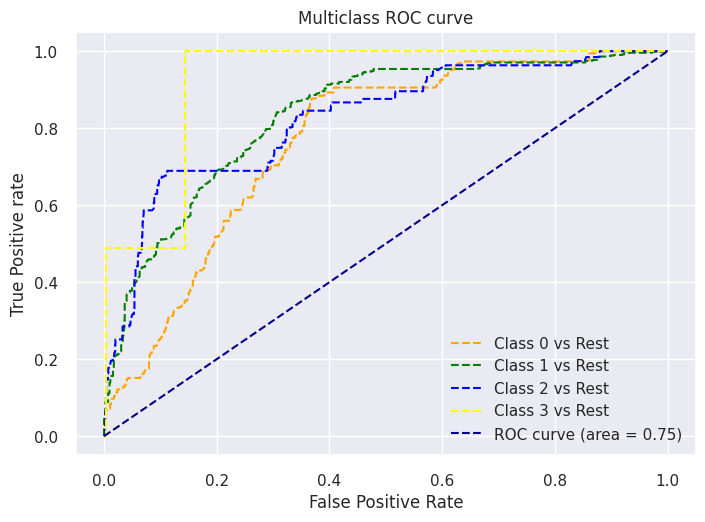

In [486]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test,y_pred_liblinear_probility[:,i], pos_label= i)
    
# plotting    
plot.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class 0 vs Rest')
plot.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class 1 vs Rest')
plot.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Class 2 vs Rest')
plot.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class 3 vs Rest')
plot.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plot.title('Multiclass ROC curve')
plot.xlabel('False Positive Rate')
plot.ylabel('True Positive rate')
plot.legend(loc='best')
plot.savefig('Multiclass ROC',dpi=300);    

In [ ]:
#https://inblog.in/AUC-ROC-score-and-curve-in-multiclass-classification-problems-2ja4jOHb2X